## Reinforcement Learning to Descend a contour

This project is to create a terrain-aware navigation/path planning agent. Goals here are to:
* Utilize reinforcement learning with PyTorch
* Determine a route that would be serviceable for pedestrian travel, whilst lowering the cost of path building

### Setup:
1. Convert DEM tiles to 2D grids
2. Define an agent that moves on the grid (8 directions) \
    a. Define state: local height patch around the agent, slope, roughness, and land-cover overlays \
    b. Action space: 8 directions (N/S/E/W/NE/NW/SE/SW) \
    c. Reward ideas: Negative reward for steep slopes or high elevation change; Positive reward for reaching a target location with minimal 'effort' (elevation). Agent's overall goal should be to get from point A to B under the most comfortable conditions, minimize distance traveled, whilst minimizing descent gradients traveled.
3. First draft model: CNN-based policy/value network with PPO or DQN for descrete actions

### Converting DEM files to 2D grids:

`ca2023_gaps_dem_*.tif` files are the DEM files (containing LiDAR-derived DEM). `ca2023_gaps_dem_*.tfw` are world files that store:
* Pixel size
* rotation
* upper-left corner coordinates

These files will be fed into Rasterio, then converted into a NumPy array that can be used by PyTorch tensors.

In [1]:
import rasterio

path = "data\ca2023_gaps_dem_J1317560tR0_C0.tif"

with rasterio.open(path) as src:
    arr = src.read(1) # elevation grid

    print(arr.shape) # get the shape of the given file
    print(src.crs) # Provides UTM zone
    print(src.transform) # Affine transformation matching the given file

(20417, 4419)
EPSG:6339
| 0.50, 0.00, 550970.50|
| 0.00,-0.50, 4125247.50|
| 0.00, 0.00, 1.00|


Notes for myself:
UTM Zone - Universal Transverse Mercator. Divides the Earth into 60 vertical strips, each 6 degrees of longitude wide.
Key points:
* Zones are numbered 1-60 from West t East
* California spans UTM Zone 10N and UTM Zone 11N
* CRS EPSG:6339 is:
    * NAD83(2011) / UTM Zone 10N
    * Measured in meters

Affine transform: a 3x3 matrix that informs rasterio on how to convert:
* Pixel coordinates -> real-world coordinates
* (row, col) -> (x,y)

Now that I've loaded one file, I'll try loading them all.

In [2]:
from pathlib import Path

data_dir = Path("data")
tif_files = sorted(data_dir.glob("*.tif"))

dem_arrays = []

for tif in tif_files:
    with rasterio.open(tif) as src:
        arr = src.read(1)
        dem_arrays.append((tif.name, arr, src.transform, src.crs))
        # name of file, elevation grid, affine transformation, coordinate reference system

Visualizing an array:

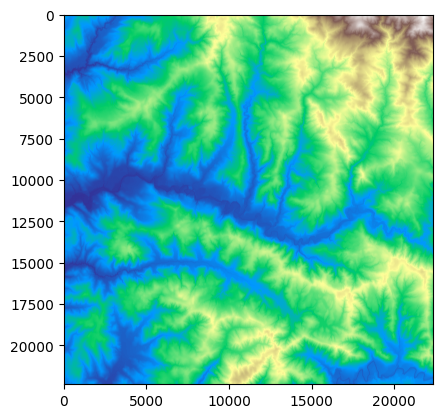

In [3]:
import matplotlib.pyplot as plt

arr = dem_arrays[4][1]
plt.imshow(arr, cmap='terrain')

##### Notes for Jarvin
OpenMP is a low-level parallelization framework used by:
* PyTorch (CPU operations)
* NumPy (when built with OpenBLAS)
* SciPy
* Rasterio (indirectly)
`OMP_NUM_THREADS` tells OpenMP to use a X number of threads.

MKL = Math Kernel Library, and powers:
* NumPy (built with MKL)
* SciPy (if built with MKL)
* PyTorch CPU ops
`MKL_NUM_THREADS` tells MKL to use X number of threads.

In [4]:
# Set CPU thread limits (put this at top of the notebook)
import os, multiprocessing
n_cpu = multiprocessing.cpu_count()
print(f"Current CPU count: {n_cpu}")

# environment vars used by BLAS/OpenMP/MKL
os.environ["OMP_NUM_THREADS"] = str(n_cpu)
os.environ["MKL_NUM_THREADS"] = str(n_cpu)

Current CPU count: 32


### Time to convert the tiles into PyTorch-ready tensors

This involves normalizing, tiling, and storing.

In [5]:
import torch
import numpy as np

# device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.benchmark = True
USE_FP16 = False
DEFAULT_DTYPE = torch.float16 if USE_FP16 else torch.float32
torch.set_num_threads(n_cpu)
torch.set_num_interop_threads(n_cpu)

def dem_to_tensor(arr, dtype = DEFAULT_DTYPE):
    # Replace no-data values if they are present
    arr = np.where(np.isnan(arr), 0, arr) # Specifcally replacing with 0


    # Min-max normalization
    arr_min = arr.min()
    arr_max = arr.max()
    arr = (arr - arr_min) / (arr_max - arr_min + 1e-8) # Adding small division to avoid divide by 0s

    tensor = torch.from_numpy(arr).unsqueeze(0).to(device=device, dtype=dtype) # Adding a channel dimension

    return tensor

cuda


In [6]:
tensor_tiles = [] # List of tuples (name, tensor, affine_transform, crs)to hold the resulting tensors

for name, arr, affine_transform, crs in dem_arrays:
    tensor = dem_to_tensor(arr)
    tensor_tiles.append((name, tensor, affine_transform, crs))

### Last steps
Turn the `tensor_tiles` into actual square patches for tiling. \
Calculate the gradients per tile.

In [7]:
import torch.nn.functional as F

def tiling(tensor, tile_size = 512):
    # Process a given tensor and ensure it has the given shape (1, H, W) where H & W are the height and width of the tensor
    _, H, W = tensor.shape
    tiles = []

    for row in range(0, H - tile_size + 1, tile_size):
        for column in range(0, W - tile_size + 1, tile_size):
            patch = tensor[:, row:row+tile_size, column:column+tile_size]
            tiles.append((patch, row, column))

    return tiles

def compute_gradients(tensor):
    # Compute gradients using Sobel filters, tiny 3x3 kernel that measures how fast values change in x/y directions

    dev, dtype = tensor.device, tensor.dtype # Ensuring that the Sobel filters are on the same device and have the same dtype as the input tensor
    sobel_x = torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ], device = dev, dtype = dtype
    )
    sobel_y = torch.tensor([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ], device = dev, dtype = dtype
    )
    
    sobel_x = sobel_x.view(1, 1, 3, 3) # Reshape to (out_channels, in_channels, kernel_height, kernel_width)
    sobel_y = sobel_y.view(1, 1, 3, 3)

    with torch.no_grad(): # No autograd needed for these operations
        tensor_batched = tensor.unsqueeze(0)

        # Convolve with the sobel filters, this is analagous to computing the partial derivatives in x/y directions
        grad_x = F.conv2d(tensor_batched, sobel_x, padding = 1) # Slide the Sobel kernel across the DEM
        grad_y = F.conv2d(tensor_batched, sobel_y, padding = 1) # Padding keeps the output the same size

        grad_magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)

    return grad_x, grad_y, grad_magnitude

In [8]:
from rasterio.transform import Affine

def tile_transform(affine_transform, row, col, pixel_size = .5):
    # Take the coordinate transformations given an Affine transformation matrix, by applying the dx/dy
    dx = col * pixel_size
    dy = row * pixel_size

    return Affine(
        affine_transform.a, affine_transform.b, affine_transform.c + dx,
        affine_transform.d, affine_transform.e, affine_transform.f + dy
    )

##### Note for Jarvin:
The following cell was a culprit for getting Out Of Memory errors. There was too much data being thrown at RAM. To deal with this, an alternative is using a [generator](https://realpython.com/introduction-to-python-generators/). This should allow for the tiles to be processed sequentially, instead of all of the data being loaded in at once. It will inevitably take a longer time to process, but will be less of a load on the CPU/RAM.

In [9]:
# # Bringing it all together, tiles into the transform and crs information
# all_tiles = []
# for name, tensor, affine_transform, crs in tensor_tiles:
#     tiles = tiling(tensor, tile_size = 512)
#     for patch, row, column in tiles:
#         patch_transform = tile_transform(
#             affine_transform, row, column
#         )
#         all_tiles.append({
#             "name": f"{name}_row{row}_column{column}",
#             "tensor": patch,
#             "affine_transform": patch_transform,
#             "crs": crs
#         })



Generators are like iterators. Calling next(gen) resumes the execution where it was last left off. In essence, it's a function that remembers. Normal functions will run everything top to bottom and return once, then forget everything. A generator pauses at `yield` and returns that value, remembers where its stack is, then resumes where it left off if called again.

Generators are lazy. They don't compute everything up front. It computes one at a time, and *only when asked*. They're perfect for:
* streaming large files
* processing huge datasets
* avoiding memory blow-ups
* pipelines where you want constant memory usage

The fix:

In [10]:
def generate_tiles(tensor, affine_transform, crs, tile_size = 512):
    tiles = tiling(tensor, tile_size)
    for patch, row, column in tiles:
        patch_transform = tile_transform(affine_transform, row, column)
        yield {
            "tensor" : patch,
            "affine_transform" : patch_transform,
            "crs" : crs
        }

In [11]:
for name, tensor, affine_transform, crs in tensor_tiles:
    for tile in generate_tiles(tensor, affine_transform, crs):
        elevation = tile["tensor"]

        grad_x, grad_y, grad_magnitude = compute_gradients(elevation)
        tile["tensor"] = torch.cat([elevation, grad_x.squeeze(0), grad_y.squeeze(0), grad_magnitude.squeeze(0)], dim=0)

### Defining the Reinforcement Learning Agent

As alluded to before, we want the agent to be able to move in the 8 classical directions. In the future, I can develop this model so that the agent is actually able to move in rotational degrees.

First thing I want to do is define an observational space for the agent. What can this agent 'observe' or see? If I give the agent the full tile, it will overfit to the data. Instead, minimize it to promote learning patterns/generalization/transferability.

In [ ]:

def get_local_window(tensor, row, column, size =33):
    # Produce a local window for the agent to observe, given a tensor and a center point (row, column) and window size
    # We need to make sure that this ALWAYS returns a size x size window, even if the center point is near the edge of the tensor
    half = size // 2
    H, W = tensor.shape[1], tensor.shape[2]

    with torch.no_grad():
        # Initial window
        window = tensor[:, max(0, row - half): min(H, row + half + 1), # to handle out of bound edge errors
                    max(0, column - half): min(W, column + half + 1)] # consider padding the tensors with 0s
        
        # Add padding
        pad_top = max(0, half - row)
        pad_left = max(0, half - column)
        pad_bottom = max(0, (row + half + 1) - H)
        pad_right = max(0, (column + half + 1) - W)

        # Use F.pad to add the padding
        window = F.pad(window, (pad_left, pad_right, pad_top, pad_bottom), mode = 'constant', value = 0)

    return window

##### Agent's observation space:
* Current window
* Distance to goal
* Most previous 2 actions
* slope magnitude